In [1]:
from skimage.io import imread, imshow, imsave
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import math
import scipy.fftpack as fp
from skimage.color import rgb2gray
from skimage import img_as_ubyte, img_as_float

In [2]:
def print_img_params(img):
    print(f'{img.shape} - shape')
    print(f'{img.min()}, {img.max()}  - min, max')
    print(f'{img.dtype}  - datatype\n')

In [3]:
def create_kernel(sigma, half):
    """Returns the kernel for the Gaussian filter with the sigma parameter.

            Args:
                    sigma (float): the parameter of the Gaussian sigma spread
                    half (int): half the width of the filter kernel (radius)

            Returns:
                    kernel (list): filter kernel
    """
    k = half * 2 + 1

    kernel = []
    for i in reversed(range(-half, half + 1)):
        for j in range(-half, half + 1):
            kernel.append((j, i))
    kernel = (np.array(kernel).reshape(k, k, 2)).tolist()
    for i in range(k):
        for j in range(k):
            kernel[i][j] = 1 / (2 * math.pi * sigma ** 2) * math.exp(- (
                kernel[i][j][0] ** 2 + kernel[i][j][1] ** 2) / (2 * sigma ** 2))
    sum = np.array(kernel).sum()
    for i in range(k):
        for j in range(k):
            kernel[i][j] = kernel[i][j] / sum

    return kernel

In [4]:
def mirror(seq, half):
    output = list(seq[::-1][-half:])
    output.extend(seq[:])
    output.extend(seq[-1:-(half + 1):-1])
    return output


def mirroring_border(arr, half):
    arr_mirrored = mirror([mirror(sublist, half) for sublist in arr], half)
    arr_mirrored = np.array(arr_mirrored)
    return arr_mirrored

In [5]:
def make_fourier_transform(img):
    freq_img = fp.fft2(rgb2gray(img))
    freq = np.log(1 + np.abs(fp.fftshift(freq_img)))
    return freq

In [6]:
def create_gaussian_pyramid(img, sigma, n_gauss_layers):

    half = round(3 * sigma)
    kernel = create_kernel(sigma, half)

    list_img_a_gauss = [img]
    list_img_a_gauss_fourier = [make_fourier_transform(img)]
    img_cycle = img.copy()
    for _ in range(n_gauss_layers - 1):
        r, g, b = np.dsplit(img_cycle, 3)
        r_mirrored, g_mirrored, b_mirrored = [
            mirroring_border(i, half) for i in (r, g, b)]
        r_gauss, g_gauss, b_gauss = [(convolve2d(i[:, :, 0], kernel, mode='valid')).astype('uint8') for i in
                                     (r_mirrored, g_mirrored, b_mirrored)]
        img_gauss = np.dstack((r_gauss, g_gauss, b_gauss))
        list_img_a_gauss.append(img_gauss)
        list_img_a_gauss_fourier.append(make_fourier_transform(img_gauss))
        img_cycle = img_gauss

    return (list_img_a_gauss, list_img_a_gauss_fourier)

In [7]:
img_a = imread('apple.png')[..., :3]

In [8]:
print_img_params(img_a)

(600, 600, 3) - shape
8, 255  - min, max
uint8  - datatype



In [9]:
sigma = 4.0

In [10]:
n_gauss_layers = 10

In [11]:
list_img_a_gauss, _ = create_gaussian_pyramid(img_a, sigma, n_gauss_layers)

In [12]:
for i in list_img_a_gauss:
    print_img_params(i)

(600, 600, 3) - shape
8, 255  - min, max
uint8  - datatype

(600, 600, 3) - shape
16, 253  - min, max
uint8  - datatype

(600, 600, 3) - shape
20, 252  - min, max
uint8  - datatype

(600, 600, 3) - shape
22, 251  - min, max
uint8  - datatype

(600, 600, 3) - shape
23, 250  - min, max
uint8  - datatype

(600, 600, 3) - shape
24, 249  - min, max
uint8  - datatype

(600, 600, 3) - shape
24, 248  - min, max
uint8  - datatype

(600, 600, 3) - shape
24, 247  - min, max
uint8  - datatype

(600, 600, 3) - shape
24, 246  - min, max
uint8  - datatype

(600, 600, 3) - shape
24, 245  - min, max
uint8  - datatype



In [13]:
np.array_equal(list_img_a_gauss[0], img_a)

True

In [14]:
img_minus = img_as_float(list_img_a_gauss[0]) - img_as_float(list_img_a_gauss[1])

In [15]:
print_img_params(img_minus)

(600, 600, 3) - shape
-0.12549019607843137, 0.20392156862745103  - min, max
float64  - datatype



In [16]:
img_minus_byte = img_as_ubyte(img_minus)

In [17]:
print_img_params(img_minus_byte)

(600, 600, 3) - shape
0, 52  - min, max
uint8  - datatype



In [18]:
list_img_a_gauss[0]

array([[[100, 106,  71],
        [102, 108,  72],
        [104, 110,  74],
        ...,
        [155, 166, 131],
        [156, 167, 133],
        [157, 167, 135]],

       [[103, 108,  73],
        [104, 109,  74],
        [107, 112,  76],
        ...,
        [153, 164, 127],
        [155, 165, 132],
        [156, 166, 134]],

       [[107, 114,  74],
        [108, 115,  75],
        [110, 116,  76],
        ...,
        [147, 159, 120],
        [153, 163, 128],
        [156, 165, 132]],

       ...,

       [[105, 138, 109],
        [105, 138, 109],
        [104, 139, 109],
        ...,
        [ 94, 106,  91],
        [ 97, 108,  95],
        [ 98, 109,  97]],

       [[111, 144, 116],
        [111, 144, 116],
        [110, 145, 116],
        ...,
        [102, 114, 100],
        [105, 116, 104],
        [107, 116, 107]],

       [[114, 147, 119],
        [114, 147, 119],
        [113, 147, 119],
        ...,
        [107, 119, 105],
        [110, 120, 109],
        [111, 120, 112]]

In [19]:
list_img_a_gauss[1]

array([[[109, 116,  74],
        [109, 116,  74],
        [109, 116,  74],
        ...,
        [148, 161, 117],
        [149, 161, 118],
        [149, 161, 119]],

       [[109, 116,  74],
        [109, 116,  74],
        [109, 116,  74],
        ...,
        [148, 161, 117],
        [149, 161, 118],
        [149, 161, 119]],

       [[109, 116,  74],
        [109, 116,  74],
        [110, 116,  74],
        ...,
        [148, 161, 116],
        [148, 161, 117],
        [149, 161, 118]],

       ...,

       [[104, 137, 106],
        [104, 137, 106],
        [104, 137, 106],
        ...,
        [ 93, 105,  89],
        [ 94, 105,  89],
        [ 94, 105,  90]],

       [[104, 138, 107],
        [104, 138, 107],
        [104, 138, 107],
        ...,
        [ 94, 106,  90],
        [ 94, 106,  90],
        [ 94, 106,  90]],

       [[105, 138, 107],
        [105, 138, 107],
        [105, 138, 107],
        ...,
        [ 94, 106,  90],
        [ 95, 106,  91],
        [ 95, 106,  91]]

In [20]:
img_minus

array([[[-0.03529412, -0.03921569, -0.01176471],
        [-0.02745098, -0.03137255, -0.00784314],
        [-0.01960784, -0.02352941,  0.        ],
        ...,
        [ 0.02745098,  0.01960784,  0.05490196],
        [ 0.02745098,  0.02352941,  0.05882353],
        [ 0.03137255,  0.02352941,  0.0627451 ]],

       [[-0.02352941, -0.03137255, -0.00392157],
        [-0.01960784, -0.02745098,  0.        ],
        [-0.00784314, -0.01568627,  0.00784314],
        ...,
        [ 0.01960784,  0.01176471,  0.03921569],
        [ 0.02352941,  0.01568627,  0.05490196],
        [ 0.02745098,  0.01960784,  0.05882353]],

       [[-0.00784314, -0.00784314,  0.        ],
        [-0.00392157, -0.00392157,  0.00392157],
        [ 0.        ,  0.        ,  0.00784314],
        ...,
        [-0.00392157, -0.00784314,  0.01568627],
        [ 0.01960784,  0.00784314,  0.04313725],
        [ 0.02745098,  0.01568627,  0.05490196]],

       ...,

       [[ 0.00392157,  0.00392157,  0.01176471],
        [ 0

In [21]:
img_minus_byte

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 7,  5, 14],
        [ 7,  6, 15],
        [ 8,  6, 16]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  2],
        ...,
        [ 5,  3, 10],
        [ 6,  4, 14],
        [ 7,  5, 15]],

       [[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  0,  2],
        ...,
        [ 0,  0,  4],
        [ 5,  2, 11],
        [ 7,  4, 14]],

       ...,

       [[ 1,  1,  3],
        [ 1,  1,  3],
        [ 0,  2,  3],
        ...,
        [ 1,  1,  2],
        [ 3,  3,  6],
        [ 4,  4,  7]],

       [[ 7,  6,  9],
        [ 7,  6,  9],
        [ 6,  7,  9],
        ...,
        [ 8,  8, 10],
        [11, 10, 14],
        [13, 10, 17]],

       [[ 9,  9, 12],
        [ 9,  9, 12],
        [ 8,  9, 12],
        ...,
        [13, 13, 15],
        [15, 14, 18],
        [16, 14, 21]]], dtype=uint8)

In [22]:
img_minus2 = list_img_a_gauss[0] - list_img_a_gauss[1]

In [23]:
img_minus2

array([[[247, 246, 253],
        [249, 248, 254],
        [251, 250,   0],
        ...,
        [  7,   5,  14],
        [  7,   6,  15],
        [  8,   6,  16]],

       [[250, 248, 255],
        [251, 249,   0],
        [254, 252,   2],
        ...,
        [  5,   3,  10],
        [  6,   4,  14],
        [  7,   5,  15]],

       [[254, 254,   0],
        [255, 255,   1],
        [  0,   0,   2],
        ...,
        [255, 254,   4],
        [  5,   2,  11],
        [  7,   4,  14]],

       ...,

       [[  1,   1,   3],
        [  1,   1,   3],
        [  0,   2,   3],
        ...,
        [  1,   1,   2],
        [  3,   3,   6],
        [  4,   4,   7]],

       [[  7,   6,   9],
        [  7,   6,   9],
        [  6,   7,   9],
        ...,
        [  8,   8,  10],
        [ 11,  10,  14],
        [ 13,  10,  17]],

       [[  9,   9,  12],
        [  9,   9,  12],
        [  8,   9,  12],
        ...,
        [ 13,  13,  15],
        [ 15,  14,  18],
        [ 16,  14,  21]]

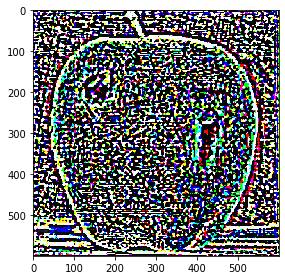

In [24]:
imshow(img_minus2);

In [25]:
print_img_params(img_minus2)

(600, 600, 3) - shape
0, 255  - min, max
uint8  - datatype



In [26]:
np.array_equal(img_minus_byte, img_minus2)

False

C:\Users\d-bug\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


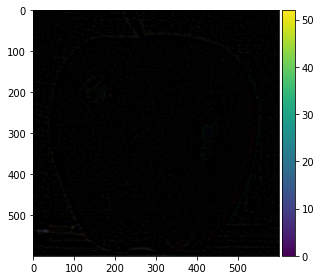

In [27]:
imshow(img_minus_byte);

In [28]:
def create_laplacian_pyramid(img, sigma, n_gauss_layers):
    list_img_gauss, _ = create_gaussian_pyramid(
        img, sigma, n_gauss_layers)

    list_img_laplace = []
    list_img_laplace_fourier = []
    for i in range(len(list_img_gauss) - 1):
        img_laplace = img_as_ubyte(img_as_float(list_img_gauss[i]) - img_as_float(list_img_gauss[i + 1]))
        img_laplace_fourier = make_fourier_transform(img_laplace)
        list_img_laplace.append(img_laplace)
        list_img_laplace_fourier.append(img_laplace_fourier)

    list_img_laplace.append(list_img_gauss[n_gauss_layers - 1]) 

    return (list_img_laplace, list_img_laplace_fourier)

In [29]:
list_img_a_laplace, list_img_a_laplace_fourier = create_laplacian_pyramid(
        img_a, sigma, n_gauss_layers)

In [30]:
list_img_a_laplace[0]

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 7,  5, 14],
        [ 7,  6, 15],
        [ 8,  6, 16]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  2],
        ...,
        [ 5,  3, 10],
        [ 6,  4, 14],
        [ 7,  5, 15]],

       [[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  0,  2],
        ...,
        [ 0,  0,  4],
        [ 5,  2, 11],
        [ 7,  4, 14]],

       ...,

       [[ 1,  1,  3],
        [ 1,  1,  3],
        [ 0,  2,  3],
        ...,
        [ 1,  1,  2],
        [ 3,  3,  6],
        [ 4,  4,  7]],

       [[ 7,  6,  9],
        [ 7,  6,  9],
        [ 6,  7,  9],
        ...,
        [ 8,  8, 10],
        [11, 10, 14],
        [13, 10, 17]],

       [[ 9,  9, 12],
        [ 9,  9, 12],
        [ 8,  9, 12],
        ...,
        [13, 13, 15],
        [15, 14, 18],
        [16, 14, 21]]], dtype=uint8)

In [31]:
img_as_float(list_img_a_laplace[0])

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.02745098, 0.01960784, 0.05490196],
        [0.02745098, 0.02352941, 0.05882353],
        [0.03137255, 0.02352941, 0.0627451 ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00784314],
        ...,
        [0.01960784, 0.01176471, 0.03921569],
        [0.02352941, 0.01568627, 0.05490196],
        [0.02745098, 0.01960784, 0.05882353]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.00784314],
        ...,
        [0.        , 0.        , 0.01568627],
        [0.01960784, 0.00784314, 0.04313725],
        [0.02745098, 0.01568627, 0.05490196]],

       ...,

       [[0.00392157, 0.00392157, 0.01176471],
        [0.00392157, 0.00392157, 0.01176471],
        [0.        , 0

In [32]:
np.array_equal(sum(list_img_a_laplace), img_a)

False

In [33]:
for i in list_img_a_laplace:
    print_img_params(i)

(600, 600, 3) - shape
0, 52  - min, max
uint8  - datatype

(600, 600, 3) - shape
0, 24  - min, max
uint8  - datatype

(600, 600, 3) - shape
0, 15  - min, max
uint8  - datatype

(600, 600, 3) - shape
0, 11  - min, max
uint8  - datatype

(600, 600, 3) - shape
0, 8  - min, max
uint8  - datatype

(600, 600, 3) - shape
0, 7  - min, max
uint8  - datatype

(600, 600, 3) - shape
0, 6  - min, max
uint8  - datatype

(600, 600, 3) - shape
0, 5  - min, max
uint8  - datatype

(600, 600, 3) - shape
0, 4  - min, max
uint8  - datatype

(600, 600, 3) - shape
24, 245  - min, max
uint8  - datatype



In [34]:
print_img_params(sum(list_img_a_laplace))

(600, 600, 3) - shape
24, 255  - min, max
uint8  - datatype



In [35]:
print_img_params(img_a)

(600, 600, 3) - shape
8, 255  - min, max
uint8  - datatype



In [36]:
sum(list_img_a_laplace)

array([[[109, 117,  74],
        [110, 117,  74],
        [110, 117,  74],
        ...,
        [155, 166, 131],
        [156, 167, 133],
        [157, 167, 135]],

       [[109, 117,  74],
        [110, 117,  74],
        [110, 117,  76],
        ...,
        [153, 164, 127],
        [155, 165, 132],
        [156, 166, 134]],

       [[109, 117,  74],
        [110, 117,  75],
        [110, 117,  76],
        ...,
        [148, 161, 120],
        [153, 163, 128],
        [156, 165, 132]],

       ...,

       [[105, 138, 109],
        [105, 138, 109],
        [104, 139, 109],
        ...,
        [ 94, 106,  91],
        [ 97, 108,  95],
        [ 98, 109,  97]],

       [[111, 144, 116],
        [111, 144, 116],
        [110, 145, 116],
        ...,
        [102, 114, 100],
        [105, 116, 104],
        [107, 116, 107]],

       [[114, 147, 119],
        [114, 147, 119],
        [113, 147, 119],
        ...,
        [107, 119, 105],
        [110, 120, 109],
        [111, 120, 112]]

In [37]:
img_a

array([[[100, 106,  71],
        [102, 108,  72],
        [104, 110,  74],
        ...,
        [155, 166, 131],
        [156, 167, 133],
        [157, 167, 135]],

       [[103, 108,  73],
        [104, 109,  74],
        [107, 112,  76],
        ...,
        [153, 164, 127],
        [155, 165, 132],
        [156, 166, 134]],

       [[107, 114,  74],
        [108, 115,  75],
        [110, 116,  76],
        ...,
        [147, 159, 120],
        [153, 163, 128],
        [156, 165, 132]],

       ...,

       [[105, 138, 109],
        [105, 138, 109],
        [104, 139, 109],
        ...,
        [ 94, 106,  91],
        [ 97, 108,  95],
        [ 98, 109,  97]],

       [[111, 144, 116],
        [111, 144, 116],
        [110, 145, 116],
        ...,
        [102, 114, 100],
        [105, 116, 104],
        [107, 116, 107]],

       [[114, 147, 119],
        [114, 147, 119],
        [113, 147, 119],
        ...,
        [107, 119, 105],
        [110, 120, 109],
        [111, 120, 112]]

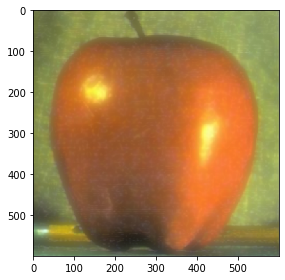

In [38]:
imshow(sum(list_img_a_laplace));

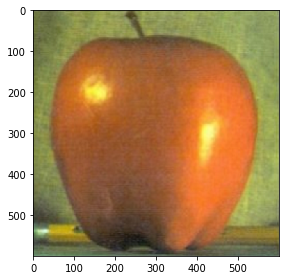

In [39]:
imshow(img_a);

In [40]:
print_img_params(img_as_float(sum(list_img_a_laplace)))

(600, 600, 3) - shape
0.09411764705882353, 1.0  - min, max
float64  - datatype



In [41]:
print_img_params(img_as_float(img_a))

(600, 600, 3) - shape
0.03137254901960784, 1.0  - min, max
float64  - datatype



In [42]:
np.array_equal(sum(list_img_a_laplace), img_a)

False

In [43]:
sum(list_img_a_laplace).sum(), img_a.sum()

(123154393, 121358275)

In [74]:
print_img_params(list_img_a_laplace_fourier[0])

(600, 600) - shape
0.0018476960930689252, 7.662251801937702  - min, max
float64  - datatype



C:\Users\d-bug\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


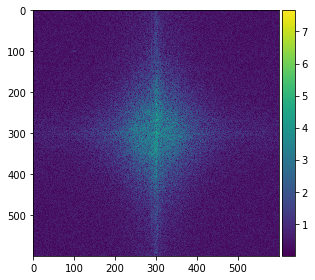

In [75]:
imshow(list_img_a_laplace_fourier[0])

In [76]:
list_img_a_laplace_fourier[0]

array([[0.60614158, 0.46825271, 0.33488061, ..., 0.27015656, 0.33488061,
        0.46825271],
       [0.33604321, 0.13617288, 0.69053045, ..., 0.19769933, 0.83321864,
        0.48880347],
       [0.40840322, 0.70124518, 0.47061234, ..., 0.45671868, 0.38418038,
        0.18312082],
       ...,
       [0.426967  , 0.22391568, 0.3220485 , ..., 0.40567421, 0.58319389,
        0.25963904],
       [0.40840322, 0.18312082, 0.38418038, ..., 0.33438409, 0.47061234,
        0.70124518],
       [0.33604321, 0.48880347, 0.83321864, ..., 0.37466986, 0.69053045,
        0.13617288]])

In [78]:
fourier_byte = list_img_a_laplace_fourier[0].astype('uint8')

C:\Users\d-bug\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


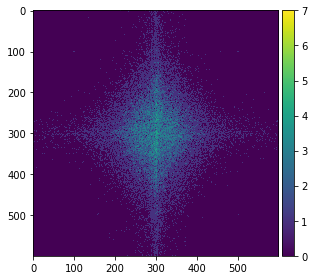

In [79]:
imshow(fourier_byte)

In [82]:
def save_laplacian_pyramid_fourier(list_laplace_fourier):
    for i, image in enumerate(list_laplace_fourier):
        imsave(f'a-laplace-fourier-{i + 1}.png', image)

In [83]:
save_laplacian_pyramid_fourier(list_img_a_laplace_fourier)

Lossy conversion from float64 to uint8. Range [0.0018476960930689252, 7.662251801937702]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.001013112468102845, 6.97989674311151]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0011638880833844604, 6.819735190633473]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0005199395254614786, 6.747677879556096]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.001840415539190146, 6.70279958932099]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.00029147577484358374, 6.669107181373932]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0006780245073203787, 6.6

In [46]:
img_b = imread('orange.png')[..., :3]

In [47]:
def create_mask(shape_0, shape_1, shape_2):
    mask = np.zeros((shape_0, shape_1, shape_2))
    mask[:, :mask.shape[1] // 2, :] = 1.0
    mask = img_as_ubyte(mask)
    return mask

In [48]:
mask = create_mask(img_a.shape[0], img_a.shape[1], img_a.shape[2])

In [49]:
mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [50]:
list_mask_gauss, _ = create_gaussian_pyramid(mask, sigma, n_gauss_layers + 1)

In [51]:
np.array_equal(list_mask_gauss[0], mask)

True

In [52]:
len(list_mask_gauss)

11

In [53]:
print_img_params(list_mask_gauss[0])

(600, 600, 3) - shape
0, 255  - min, max
uint8  - datatype



In [54]:
list_mask_gauss[5]

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [55]:
img_as_float(list_mask_gauss[5])

array([[[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0

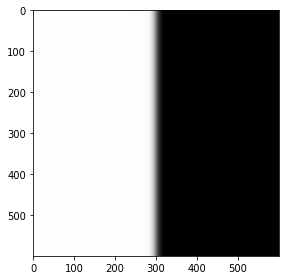

In [56]:
imshow(list_mask_gauss[5])

In [57]:
imsave('mask-white-black-gauss-5.png', list_mask_gauss[5])

In [58]:
def blend_images(img_1, img_2, mask, sigma, n_gauss_layers):
    list_mask_gauss, _ = create_gaussian_pyramid(
        mask, sigma, n_gauss_layers + 1)
    list_img_1_laplace, _ = create_laplacian_pyramid(
        img_1, sigma, n_gauss_layers)
    list_img_2_laplace, _ = create_laplacian_pyramid(
        img_2, sigma, n_gauss_layers)
    
    list_blended = []
    for i in range(n_gauss_layers):
        layer_blended = img_as_float(list_mask_gauss[i + 1]) * img_as_float(list_img_1_laplace[i]) + \
            (1 - img_as_float(list_mask_gauss[i + 1])) * img_as_float(list_img_2_laplace[i])
        list_blended.append(layer_blended)
        
    img_blended = img_as_ubyte(sum(list_blended))
    
    return (list_blended, img_blended)

In [59]:
list_blended, img_blended = blend_images(img_a, img_b, mask, sigma, n_gauss_layers)

In [60]:
print_img_params(img_blended)

(600, 600, 3) - shape
4, 255  - min, max
uint8  - datatype



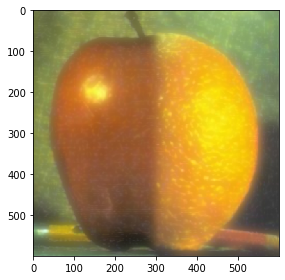

In [61]:
imshow(img_blended);

In [62]:
imsave('apple-orange-blended-4.0-10.png', img_blended)

In [63]:
len(list_blended)

10

In [64]:
print_img_params(list_blended[0])

(600, 600, 3) - shape
0.0, 0.20315263360246058  - min, max
float64  - datatype



In [65]:
print_img_params(list_blended[len(list_blended) - 1])

(600, 600, 3) - shape
0.01568627450980392, 0.9568627450980391  - min, max
float64  - datatype



In [66]:
list_blended[0]

array([[[0.00000000e+00, 0.00000000e+00, 9.22722030e-05],
        [0.00000000e+00, 0.00000000e+00, 6.15148020e-05],
        [0.00000000e+00, 0.00000000e+00, 1.53787005e-05],
        ...,
        [7.84313725e-03, 0.00000000e+00, 7.84313725e-03],
        [2.35294118e-02, 1.96078431e-02, 2.74509804e-02],
        [3.52941176e-02, 2.74509804e-02, 3.52941176e-02]],

       [[0.00000000e+00, 0.00000000e+00, 7.68935025e-05],
        [0.00000000e+00, 0.00000000e+00, 6.15148020e-05],
        [0.00000000e+00, 0.00000000e+00, 7.84313725e-03],
        ...,
        [3.92156863e-03, 0.00000000e+00, 3.92156863e-03],
        [2.74509804e-02, 1.56862745e-02, 2.35294118e-02],
        [3.92156863e-02, 2.74509804e-02, 3.52941176e-02]],

       [[0.00000000e+00, 0.00000000e+00, 1.53787005e-05],
        [0.00000000e+00, 0.00000000e+00, 3.92156863e-03],
        [0.00000000e+00, 0.00000000e+00, 7.82775855e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.96078431e-02, 1.17

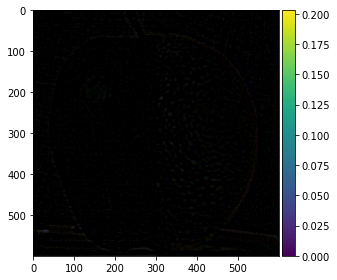

In [67]:
imshow(list_blended[0])

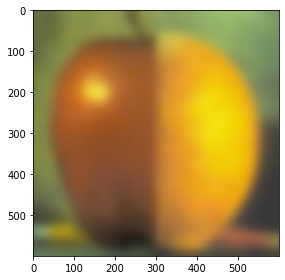

In [68]:
imshow(list_blended[len(list_blended) - 1]);

In [69]:
img_blended_rough = img_a.copy()

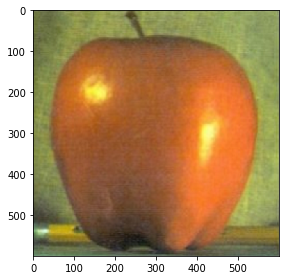

In [70]:
imshow(img_blended_rough);

In [71]:
img_blended_rough[:, 300:, ] = img_b[:, 300:, ]

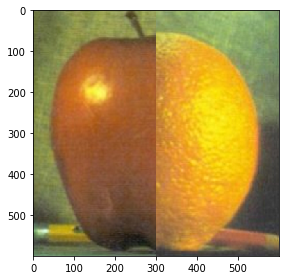

In [72]:
imshow(img_blended_rough);

In [73]:
imsave('apple-orange-blended-rough.png', img_blended_rough)